In [6]:
import pandas as pd
import numpy as np
import datetime
from os.path import join
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale = 2)
import joblib
import os

In [7]:
def plot_total_cp(reports, preds, model_name, neighborhood_thresh=0.1, ax=0):
    
    df = pd.DataFrame(columns=['Storm Mode', 'Hazard', 'Cond Prob'])
    i=0
    for hazard in ['torn', 'wind', 'hail']:
        for mode in ['Supercell', 'QLCS', 'Disorganized']:
            cp = hazard_cond_prob(reports, preds, model_name, hazard, mode, neighborhood_thresh)
            df.loc[i] = [mode, hazard, cp]
            i += 1
            
    # plt.figure(figsize=(16,10))
    ax.grid(linewidth=0.25)
    sns.barplot(hue='Hazard', y='Cond Prob', x='Storm Mode', data=df, palette=['r','b','g'], ax=ax)
    ax.set_ylim(0, 0.052)
    ax.set_ylabel('Conditional Probability', fontsize=11)
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_cond_prob_2016.png', dpi=300, bbox_inches='tight')
    return

def plot_rel_diagram_neighborhood(reports, preds, model_name, bin_width, bin_max=0.36, ax=0): 
    df = pd.DataFrame(columns=['Storm Mode', 'Hazard', 'Cond Prob', 'Neighborhood Prob'])
    i=0

    for hazard in ['torn', 'hail', 'wind']:
        for mode in ['Supercell', 'QLCS']:
            for nproby in np.arange(0.0, bin_max, bin_width):
                cp = hazard_cond_prob(reports, preds, model_name, hazard, mode, nproby, nproby + bin_width)
                df.loc[i] = [mode, hazard, cp, nproby]
                i += 1
    df['Cond Prob'].replace(0, np.nan, inplace=True)

    # plt.figure(figsize=(16,10))
    for j, hazard in enumerate(['torn', 'hail', 'wind']):
        for mode in ['Supercell', 'QLCS']:
            
            if mode == 'Supercell':
                ltype = ['r-o', 'g-o', 'b-o']
            elif mode == 'QLCS':
                ltype = ['r--o', 'g--o', 'b--o']
                
            df_sub = df.loc[(df['Storm Mode'] == mode) & (df['Hazard'] == hazard)]
            
            ax.plot(df_sub['Neighborhood Prob'], df_sub['Cond Prob'], ltype[j], label=f'{hazard.capitalize()} | {mode}')
            ax.set_ylim(0, 0.12)
            ax.set_xlim(0, bin_max)
            ax.set_xlabel('Neighborhood Probability', fontsize=10)
            ax.set_ylabel('Conditional Probability', fontsize=10)
        ax.grid(linewidth=0.25)
        ax.legend(loc='upper left')
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_nprob_2016.png', dpi=300, bbox_inches='tight')
    return

def plot_rel_diagram_ML_prob(reports, preds, model_name, bin_width, nprob_thresh=0.02): 
    print(model_name)
    df = pd.DataFrame(columns=['Storm Mode', 'Hazard', 'Cond Prob', 'ML Prob'])
    i=0
    
    for hazard in ['torn', 'hail', 'wind']:
        for mode in ['Supercell', 'QLCS']:
            for ml_bin in np.arange(0, 1, bin_width):
                mask = xr.where((preds[f'{model_name}_{mode}_prob'] > ml_bin) & (preds[f'{model_name}_{mode}_prob'] <= ml_bin + bin_width), 1, 0)
                ds = preds.where(mask)
                cp = hazard_cond_prob(reports, ds, model_name, hazard, mode, nprob_thresh)
                df.loc[i] = [mode, hazard, cp, f'{np.round(ml_bin, 1)}-{np.round(ml_bin + bin_width, 1)}']
                i += 1
    df['Cond Prob'].replace(0, np.nan, inplace=True)
    
    plt.figure(figsize=(16,10))
    for j, hazard in enumerate(['torn', 'hail', 'wind']):
        for mode in ['Supercell', 'QLCS']:
            if mode == 'Supercell':
                ltype = ['r-o', 'g-o', 'b-o']
            elif mode == 'QLCS':
                ltype = ['r--o', 'g--o', 'b--o']
            df_sub = df.loc[(df['Storm Mode'] == mode) & (df['Hazard'] == hazard)]
            plt.plot(df_sub['ML Prob'], df_sub['Cond Prob'], ltype[j], label=f'{hazard.capitalize()} | {mode}')
            # plt.ylim(0, 0.03)
            # plt.xlim(0, 100)
            plt.xlabel('ML Probability', fontsize=18)
            plt.ylabel('Conditional Probability', fontsize=18)
        plt.legend()
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_ML_prob_2016.png', dpi=300, bbox_inches='tight')
    return

def plot_modes_spatial(labels, model_name, ax=0):
    
    # fig = plt.figure(figsize=(40, 20), constrained_layout=True)
    # lcc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    # ax = fig.add_subplot(1, 1, 1, projection=lcc)
    
    #ax.set_extent([-121,-74,25,50], ccrs.PlateCarree())
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.OCEAN)
    #ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.BORDERS)
    #ax.add_feature(cfeature.LAKES, alpha=0.5)
    #ax.add_feature(cfeature.STATES)
    
    ax.set_extent([-121,-74,25,50], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), linewidth=0.1, color='gray', alpha=0.2)


    #colors = sns.color_palette("dark", 3)
    data = labels.groupby(f'{model_name}_label').apply(lambda x: x.sort_values(f'{model_name}_label_prob', ascending=False))

    colors = ['red', 'blue', 'green']
    for i, mode in enumerate(['Supercell', 'QLCS', 'Disorganized']):
        print(model_name, mode)
        these_data = data.loc[mode][:10000]
        
        #ax.scatter(x=data['Centroid_Lon'], y=data['Centroid_Lat'], transform=ccrs.PlateCarree(), label=None, color=colors[i], alpha=0.25, s=2.5)
        b = sns.kdeplot(x=these_data['Centroid_Lon'], y=these_data['Centroid_Lat'], data=these_data[f'{model_name}_label_prob'], levels=[0.5, 0.66, 0.83], transform=ccrs.PlateCarree(), 
                    linewidths=2, thresh=0.5, gridsize=100, color=colors[i], linestyles='-', label=mode, hue_order=['Supercell', 'QLCS', 'Disorganized'], ax=ax)
        
    #ax.legend(prop={'size': 10})
        
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_spatial_2016.png', dpi=300, bbox_inches='tight')
    return

def plot_modes_diurnal(labels, model_name, n_runs=83, ax=0):
    # fig, ax = plt.subplots(figsize=(20, 8))

    for i, mode in enumerate(['Disorganized', 'Supercell', 'QLCS']):

        data = labels.groupby(f'{model_name}_label').apply(lambda x: x.sort_values(f'{model_name}_label_prob', ascending=False)).loc[mode]
        data.Valid_Date = data.Valid_Date - pd.Timedelta(6, 'H')
        ts = data.groupby(data['Valid_Date'].dt.hour)[f'{model_name}_label'].count() / n_runs
        
        colors = sns.color_palette("dark", 3)
        ax.plot(ts, linewidth=4, alpha=1, label=mode, color=colors[i])
        ax.legend(prop={'size': 16})
        # plt.title(f'Diurnal Distribution of Storm Modes', fontsize=30)
        ax.set_ylabel('Number of Storms', fontsize=20)
        ax.set_xlabel('UTC - 6', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_diurnal_2016.png', dpi=300, bbox_inches='tight')
    return

def plot_modes_diurnal_r(labels, mode, n_runs=83, ax=0):
    
    # fig, ax = plt.subplots(figsize=(20, 8))
    model_names = ['CNN', 'GMM', 'DNN', 'LR']
    for i, model_name in enumerate(['CNN_1', 'SS', 'DNN_1', 'LR']):

        data = labels.groupby(f'{model_name}_label').apply(lambda x: x.sort_values(f'{model_name}_label_prob', ascending=False)).loc[mode]
        data.Valid_Date = data.Valid_Date - pd.Timedelta(6, 'H')
        #ts = data.groupby(data['Valid_Date'].dt.hour)[f'{model_name}_label'].count() / n_runs
        ts = data.groupby(data['Forecast_Hour'])[f'{model_name}_label'].count() / n_runs
        
        colors = sns.color_palette("deep", 4)
        ax.plot(ts, linewidth=4, alpha=1, label=model_names[i], color=colors[i])
        #ax.legend(prop={'size': 12})
        # plt.title(f'Diurnal Distribution of Storm Modes', fontsize=30)
        ax.set_ylabel('Mean Storms per \n Model Run', fontsize=14)
        ax.set_xlabel('UTC', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_diurnal_2016.png', dpi=300, bbox_inches='tight')
    return

def plot_modes_CS(labels, model_name, ax=0):
    # plt.figure(figsize=(20, 16))
    #sns.set(font_scale=1.5)
    colors = sns.color_palette("dark", 3)
    labels['Shear'] = np.sqrt(labels['USHR6-potential_mean'] ** 2 + labels['VSHR6-potential_mean'] ** 2)
    
    g = sns.kdeplot(data=labels, x='MLCAPE-potential_mean', y='Shear', hue=f'{model_name}_label', hue_order=['Supercell', 'QLCS', 'Disorganized'], fill=True, alpha=0.25, thresh=0.25, levels=6,
                palette=colors, gridsize=100, clip=(0, 4000), linewidths=10, legend=True, common_norm=False, ax=ax)
    
    #g = sns.kdeplot(data=labels, x='MLCAPE-potential_mean', y='Shear', hue=f'{model_name}_label', hue_order=['Supercell', 'QLCS', 'Disorganized'], fill=False, thresh=0.25, levels=5, alpha=0.75, \
    #            palette=colors, gridsize=100, clip=(0, 4000), linewidths=2, legend=True, common_norm=False, ax=ax)
    ax.grid(linewidth=0.25)
    g.legend_.set_title(None)
    ax.set_ylim(0, 40)
    # plt.savefig(f'/glade/work/cbecker/HWT_val_output/{model_name}_CapeShear_2016.png', dpi=300, bbox_inches='tight')
    return

def hazard_cond_prob(obs, preds, model_name, A, B, nprob_thresh=0.02, secondary_thresh=None):
    """
    Get conditional probability. Supports binning of neighborhood probabilities.
    Args:
        obs: SPC Observations array
        preds: HWT mode predictions array
        A: SPC Hazard ('Torn', 'Hail', 'Wind') or proxy hazard variable
        B: Condition - Storm Mode prediction ('Supercell', 'QLCS', 'Disorganized')
        nprob_thresh: Threshold of neighborhood probability (used as lower threshold when binning)
        secondary_thresh: Upper threshhold for binning (default None)
    Returns: Conditional probability: P(A|B)
    """
    if secondary_thresh is not None:
        arr = np.where((preds[f'{model_name}_{B}_nprob'] > nprob_thresh) & (preds[f'{model_name}_{B}_nprob'] <= secondary_thresh), 1, 0)
        hits = np.where((arr >= 1) & (obs[A].values >= 1), 1, 0).sum()
        mode_bin = np.where(arr >= 1, 1, 0).sum()
    else:
        hits = np.where((preds[f'{model_name}_{B}_nprob'] > nprob_thresh).values & (obs[A] >= 1).values, 1, 0).sum()
        mode_bin = np.where(preds[f'{model_name}_{B}_nprob'] > nprob_thresh, 1, 0).sum()
    cond_prob = hits / mode_bin

    return cond_prob


def plot_storm_clusters(patch_data_path, output_path, cluster_data, n_storms=5, patch_radius=48, prob_type='highest',
                        seed=88):
    """
    Args:
        patch_data_path: Path where storm patches are located.
        output_path: Output path to save file.
        cluster_data: Neuron activation dataframe with cluster labels
        n_storms: Number of storms to plot per cluster (should be an even square - 4, 9. 16, 25, ...)
        prob_type: Probability of storms to plot (only valid for 'GMM'). Should be 'highest', 'lowest', or 'random'
        seed: Random seed used for sampling.
    Returns:
    """
    ms_mph = 2.237
    file_dates = sorted(pd.to_datetime(cluster_data['Run_Date'].unique()))
    file_paths = sorted(
        [join(patch_data_path, f'NCARSTORM_{x.strftime("%Y%m%d")}-0000_d01_model_patches.nc') for x in file_dates])
    ds = xr.open_mfdataset(file_paths, combine='nested', concat_dim='p', parallel=True)

    n_clusters = cluster_data['SS_label'].nunique()

    fig, axes = plt.subplots(n_clusters, n_storms, figsize=(26, 62), sharex=True, sharey=True, constrained_layout=True)
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    
    # for cluster in range(n_clusters):
    # for c, cluster in enumerate(range(2)):
    for c, cluster in enumerate(ordered_clusters):
        if cluster in clusters['Supercell']:
            mode = 'Supercell'
        elif cluster in clusters['QLCS']:
            mode = 'QLCS'
        else:
            mode = 'Disorganized'
        print(f"Plotting sample storms with {prob_type} probabilities for cluster {cluster}.")
        if prob_type == 'highest':
            sub = cluster_data[cluster_data['SS_label'] == cluster].sort_values(['SS_label_prob'], ascending=False)[:n_storms]
        elif prob_type == 'lowest':
            sub = cluster_data[cluster_data['SS_label'] == cluster].sort_values(['SS_label_prob'], ascending=True)[:n_storms]
        elif prob_type == 'random':
            sub = cluster_data[cluster_data['SS_label'] == cluster].sample(n_storms, random_state=seed)

        storm_idxs = sub.index.values
        patch_center = int(ds.row.size / 2)
        refl_var = [v for v in ds.data_vars if "REFL" in v][0]
        x = ds[[refl_var, 'U10_curr', 'V10_curr', 'masks', 'UP_HELI_MAX_curr']].isel(p=storm_idxs, row=slice(patch_center - patch_radius, patch_center + patch_radius),
                                                               col=slice(patch_center - patch_radius, patch_center + patch_radius)).load()
        wind_step = int(np.ceil(np.sqrt(x.row.size)))
        wind_slice = (slice(wind_step, None, wind_step), slice(wind_step, None, wind_step))
        x_mesh, y_mesh = np.meshgrid(range(len(x['row'])), range(len(x['col'])))


        for i in range(n_storms):
            try:
                im = axes[c, i].contourf(x['REFL_COM_curr'][i], levels=np.linspace(0, 80, 25), vmin=0, vmax=80, cmap='gist_ncar')
            except:
                continue
            if i == 0:
                axes[c, i].set_ylabel(f'Cluster {cluster}\n ({mode})', fontsize=16)
            axes[c, i].contour(x['masks'][i], colors='k')
            axes[c, i].contour(x['UP_HELI_MAX_curr'][i], levels=[75, 500], vmin=75, colors='k', alpha=0.5)
            axes[c, i].contourf(x['UP_HELI_MAX_curr'][i], levels=[75, 500], vmin=75, colors='k', alpha=0.25)
            axes[c, i].barbs(x_mesh[wind_slice], y_mesh[wind_slice], x['U10_curr'][i][wind_slice] * ms_mph, x['V10_curr'][i][wind_slice] * ms_mph, color='grey', pivot='middle', length=6)

            axes[c, i].text(6, 11, f"P = {str(np.round(sub.iloc[i, :]['SS_label_prob'], 2))}", style='italic', fontsize=10, bbox={'facecolor': 'lightgrey', 'alpha': 0.8, 'pad': 8})

            plt.subplots_adjust(right=0.975)
            cbar_ax = fig.add_axes([1, 0.125, 0.025, 0.83])
            fig.colorbar(im, cbar_ax)
            axes[c, i].set_xticks([])
            axes[c, i].set_xticks([], minor=True)
            axes[c, i].set_yticks([])
            axes[c, i].set_yticks([], minor=True)

        # plt.suptitle(f'Storm Clusters', fontsize=44)
        plt.subplots_adjust(top=1)
        # plt.savefig('/glade/work/cbecker/clusters_top_paper_val_draft_UH.png', dpi=300, bbox_inches='tight')
        # plt.savefig('/glade/work/cbecker/HWT_val_output/clusters_top_paper_val_draft_UH.pdf', bbox_inches='tight')

In [3]:
# this takes a long time, don't run
%%time
start_date = "2016-01-01"
end_date = "2016-12-31"
storm_report_path = "/glade/work/cbecker/SPC_storm_reports/"
# base_path = '/glade/work/cbecker/HWT/HWT_evaluation_WRF/HWT_2016_validation/'
base_path = "/glade/scratch/cbecker/WRF_labels_20220923/"
model_grid_path = "/glade/work/cbecker/HWT_mode/model_grids/NCEP_211_grid.nc"
proj_str = "+proj=lcc +lat_0=38.336433 +lon_0=-101 +lat_1=32 +lat_2=46 +a=6370000 +b=6370000"

obs = generate_obs_grid(start_date=start_date,
                        end_date=end_date,
                        storm_report_path=storm_report_path,
                        model_grid_path=model_grid_path,
                        proj_str=proj_str)

probs = load_probabilities(start_date, 
                           end_date, 
                           join(base_path, "evaluation/"), 
                           "daily", 
                           "nc")

labels = load_labels(start=start_date,
                     end=end_date,
                     label_path=join(base_path, "labels"),
                     run_freq="daily",
                     file_format="parquet")

matched_obs = obs.swap_dims({'time':"valid_time"}).sel(valid_time=probs['valid_time'])
matched_obs = matched_obs.rename({'torn': 'Tornado', 'wind': 'Wind', 'hail': 'Hail'})

UsageError: Line magic function `%%time` not found.


In [16]:
# %%time
# ### write the combined data out
# obs.to_netcdf('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_obs.nc')
# matched_obs.to_netcdf('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/matched_obs.nc')
# labels.to_parquet('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_labels.parquet')
# probs.to_netcdf('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_probs.nc')

In [8]:
%%time
# Open combined data
#obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_obs.nc') # all binary observations for 2016 on 80-km grid
#probs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_probs.nc') # neighborhood prob files for each NCAR700 forecast on 80-km grid
#matched_obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/matched_obs.nc') # binary observations for NCAR700 forecasts on 80-km grid
#labels = pd.read_parquet('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_labels.parquet') # raw probability file for each storm object (not on 80-km grid)

obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_obs_2016_2019.nc') # all binary observations for 2016 on 80-km grid
probs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_probs_2016_2019_w_LR.nc') # neighborhood prob files for each NCAR700 forecast on 80-km grid
matched_obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/matched_obs_2016_2019.nc') # binary observations for NCAR700 forecasts on 80-km grid
labels = pd.read_parquet('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_labels_2016_2019_w_LR.parquet') # raw probability file for each storm object (not on 80-km grid)

# only use 2016 forecasts
probs = probs.where(probs['init_time'] <= np.datetime64('2016-12-31'), drop=True)
labels = labels[labels['Run_Date'] <= np.datetime64('2016-12-31')]
matched_obs = obs.swap_dims({'time':"valid_time"}).sel(valid_time=probs['valid_time'])

# SS_label field shows cluster label??
categories = { 0: 'QLCS', 1: 'Supercell', 2: 'Disorganized' }
labels['SS_label'] = np.argmax( labels[['SS_QLCS_prob','SS_Supercell_prob','SS_Disorganized_prob']].values , axis=1)
labels['SS_label'] = labels['SS_label'].apply(lambda x: categories[x])

# Add LR_label_prob column
lr_prob_values = labels[['LR_QLCS_prob', 'LR_Supercell_prob', 'LR_Disorganized_prob']].values
lr_prob_argmax = np.argmax(lr_prob_values, axis=1)
labels['LR_label_prob'] = lr_prob_values[range(lr_prob_argmax.size), lr_prob_argmax]

# questions for Charlie...
# fix SS_label issue above
# use average of 5 CNNs to be consistent (probably wont change much)
# is GMM trained with what hagelslag objects?
# are there missing hours in neighborhood probs (e.g., when no objects present)? 8 May 2016 only has 19 hours

CPU times: user 889 ms, sys: 1.76 s, total: 2.65 s
Wall time: 4.86 s


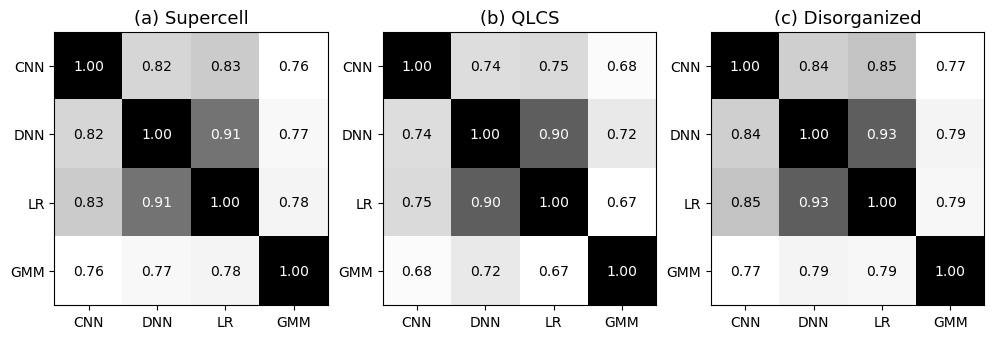

In [9]:
import scipy.stats
import matplotlib as mpl
mpl.rc_file_defaults()
panels = ['a', 'b', 'c', 'd']

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes = axes.flatten()

for n, mode in enumerate(['Supercell', 'QLCS', 'Disorganized']):
    list1 = []
    for model1 in ['CNN_1', 'DNN_1', 'LR', 'SS']:
        list2 = []
        for model2 in ['CNN_1', 'DNN_1', 'LR', 'SS']:
            r = scipy.stats.pearsonr(labels[f'{model1}_{mode}_prob'], labels[f'{model2}_{mode}_prob'])[0]
            list2.append(r)
        list1.append(list2)
        
    axes[n].imshow(list1, cmap=mpl.cm.Greys)
    axes[n].set_xticks([0,1,2,3])
    axes[n].set_xticklabels(['CNN', 'DNN', 'LR', 'GMM'])
    axes[n].set_yticks([0,1,2,3])
    axes[n].set_yticklabels(['CNN', 'DNN', 'LR', 'GMM'])
    axes[n].set_title('(%s) %s'%(panels[n], mode), fontsize=13)
    
    for i,row in enumerate(list1):
        for j,val in enumerate(row):
            if val < 0.9: axes[n].text(i, j, '%.2f'%val, ha='center', va='center', size=10)
            else: axes[n].text(i, j, '%.2f'%val, color='white', ha='center', va='center', size=10)
            
plt.savefig('corr_matrix.png', bbox_inches='tight')

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1


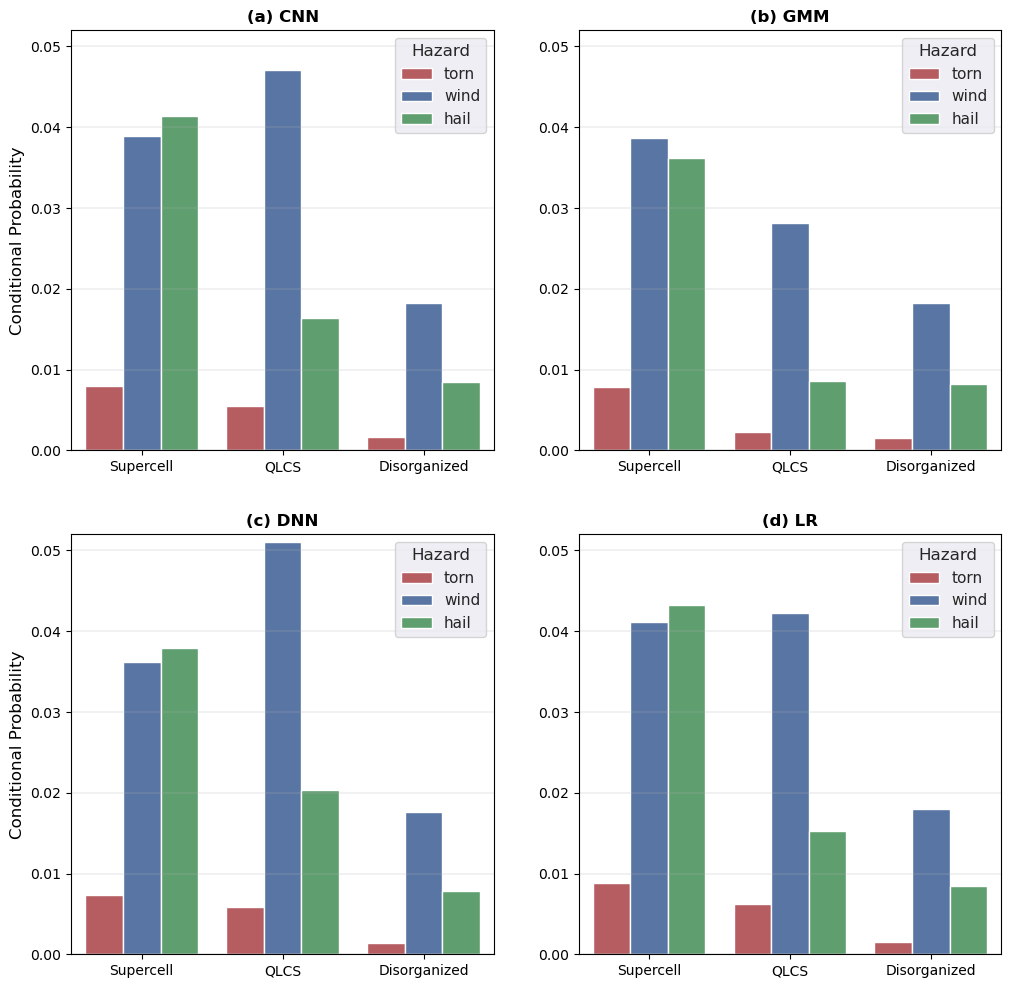

In [10]:
model_names = ['CNN', 'GMM', 'DNN', 'LR']
model_list = ['CNN_1', 'SS', 'DNN_1', 'LR']

fig, axes = plt.subplots(2, 2, figsize=(12,12))
sns.set(font_scale = 1)

for i, ax in enumerate(axes.ravel()):
    plot_total_cp(matched_obs, probs, model_list[i], neighborhood_thresh=0.1, ax=ax)
    ax.set_xlabel(None)
    ax.set_title(f'({panels[i]}) {model_names[i]}', fontsize=12, weight='bold')
    if i in [0,2]: ax.set_ylabel('Conditional Probability', fontsize=12)
    else: ax.set_ylabel(None)
            
plt.savefig('cond_prob_bar.png', bbox_inches='tight')

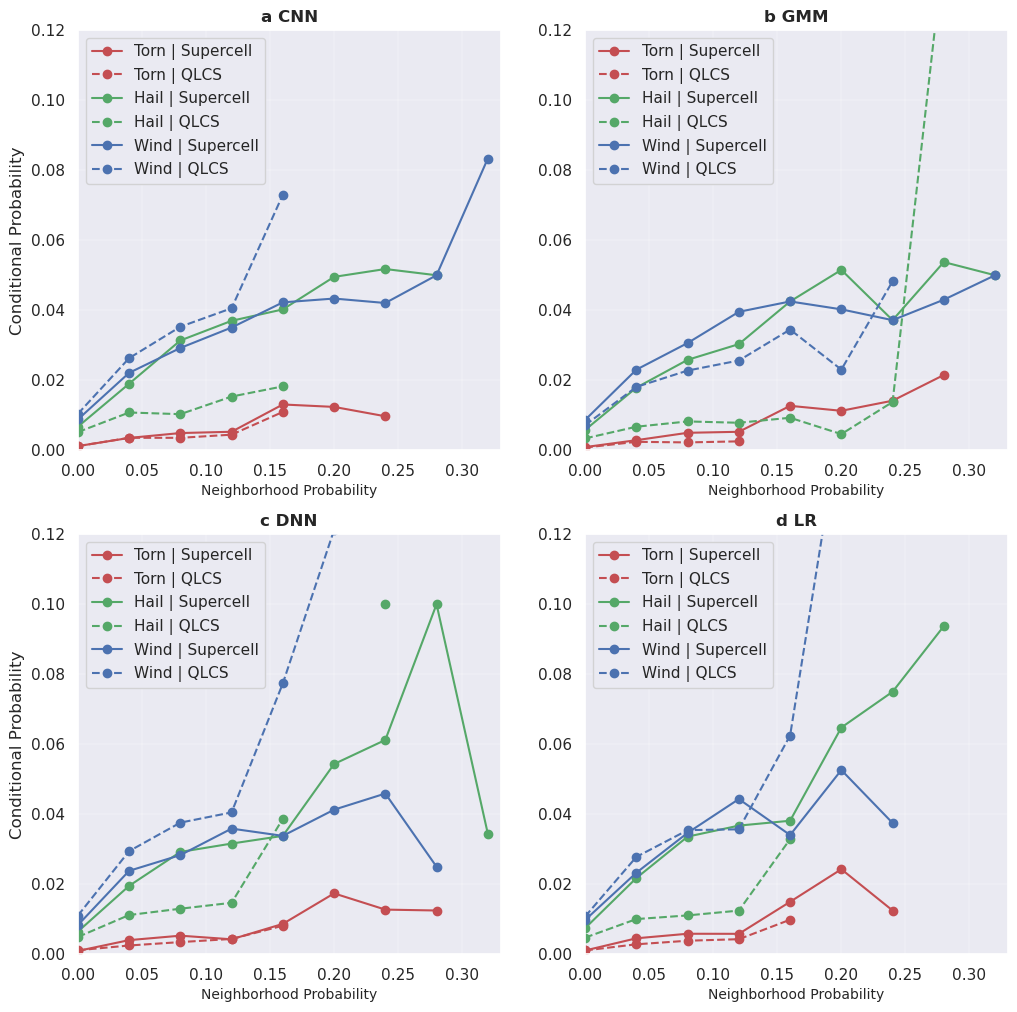

In [6]:
model_names = ['CNN', 'GMM', 'DNN', 'LR']
model_list = ['CNN_1', 'SS', 'DNN_1', 'LR']

fig, axes = plt.subplots(2, 2, figsize=(12,12))
for i, ax in enumerate(axes.ravel()):
    plot_rel_diagram_neighborhood(matched_obs, probs, model_list[i], 0.04, 0.33, ax=ax)
    if i in [0,2]: ax.set_ylabel('Conditional Probability', fontsize=12)
    else: ax.set_ylabel(None)
    ax.set_title(f'{panels[i]} {model_names[i]}', fontsize=12, weight='bold')

plt.savefig('cond_prob_line.pdf', bbox_inches='tight')

CNN_1 Supercell
CNN_1 QLCS
CNN_1 Disorganized
SS Supercell
SS QLCS
SS Disorganized
DNN_1 Supercell
DNN_1 QLCS
DNN_1 Disorganized
LR Supercell
LR QLCS
LR Disorganized
CPU times: user 13.7 s, sys: 17 ms, total: 13.7 s
Wall time: 14 s


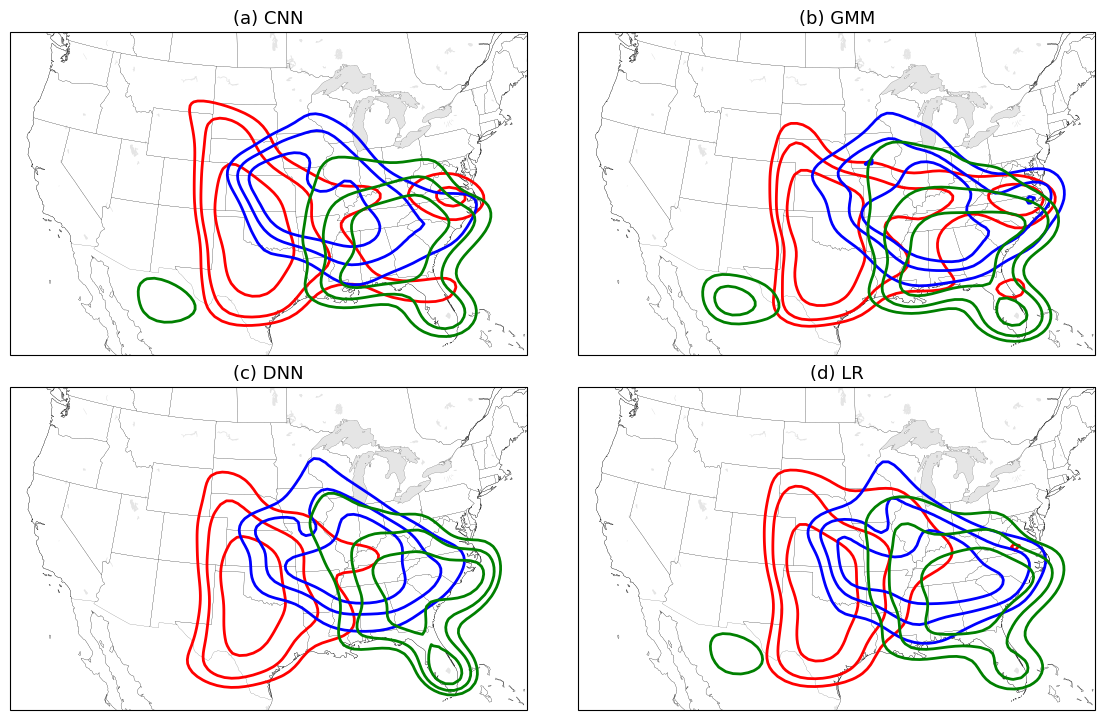

In [21]:
%%time
model_list = ['CNN_1', 'SS', 'DNN_1', 'LR']
model_names = ['CNN', 'GMM', 'DNN', 'LR']
panels = ['(a)', '(b)', '(c)', '(d)']
lcc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig = plt.figure(figsize=(14,9), constrained_layout=False)
fig.subplots_adjust(hspace=0.05, wspace=0.1)

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=lcc)
    plot_modes_spatial(labels, model_list[i], ax=ax)
    ax.set_xlabel(None)
    ax.set_title('%s %s'%(panels[i], model_names[i]), fontsize=13)

plt.savefig('spatial_mode.png', bbox_inches='tight')

CPU times: user 35.4 s, sys: 16.4 ms, total: 35.4 s
Wall time: 36 s


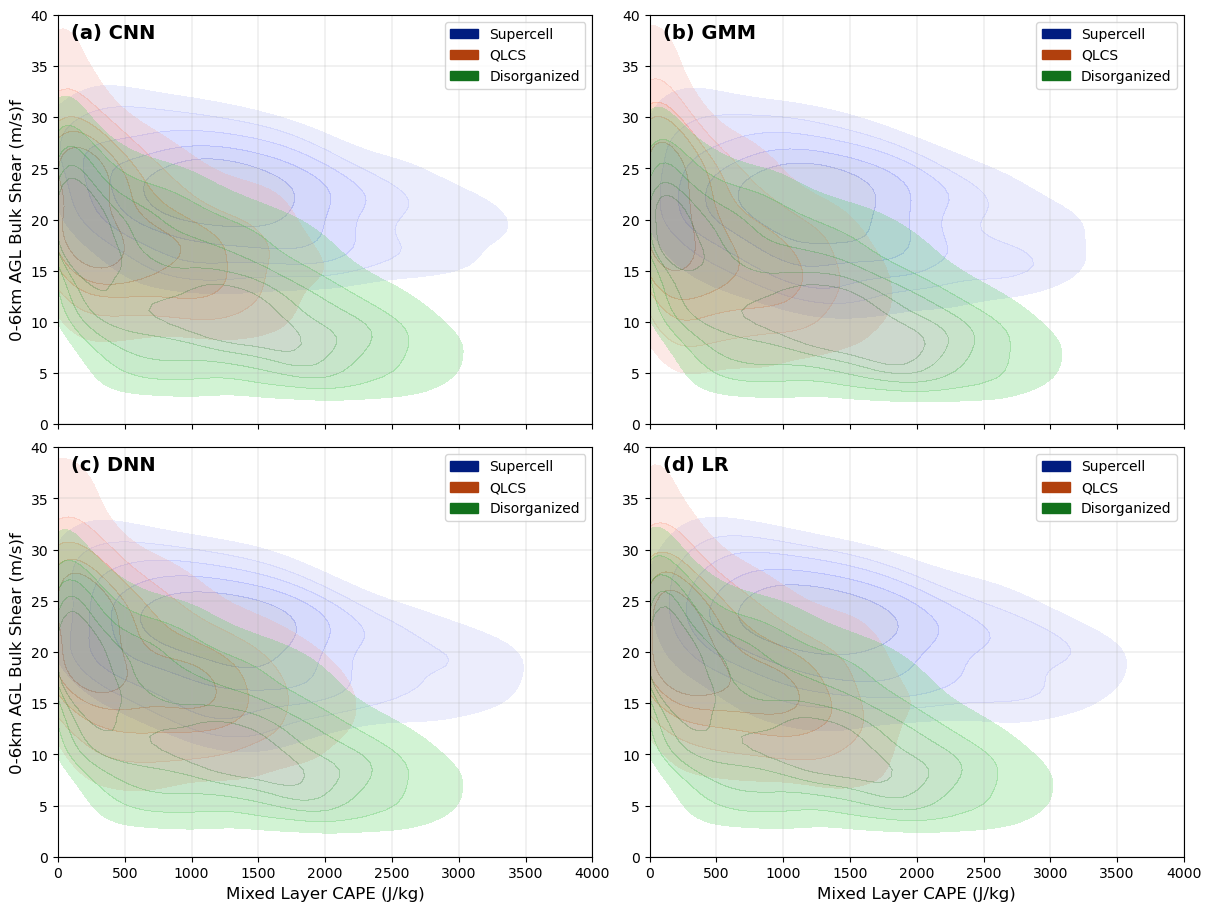

In [10]:
%%time
model_list = ['CNN_1', 'SS', 'DNN_1', 'LR']
model_names = ['CNN', 'GMM', 'DNN', 'LR']
panels = ['a', 'b', 'c', 'd']
fig = plt.figure(figsize=(12,9), constrained_layout=True)

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    plot_modes_CS(labels, model_list[i], ax=ax)
    if i in [0,1]:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    if i in [2,3]: ax.set_xlabel('Mixed Layer CAPE (J/kg)', fontsize=12)
    if i in [0,2]: ax.set_ylabel('0-6km AGL Bulk Shear (m/s)', fontsize=12)
    else: ax.set_ylabel(None)
    ax.text(0.025, 0.98, f'({panels[i]}) {model_names[i]}', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

plt.savefig('cape_shear.png', bbox_inches='tight')

CPU times: user 892 ms, sys: 6.87 ms, total: 899 ms
Wall time: 933 ms


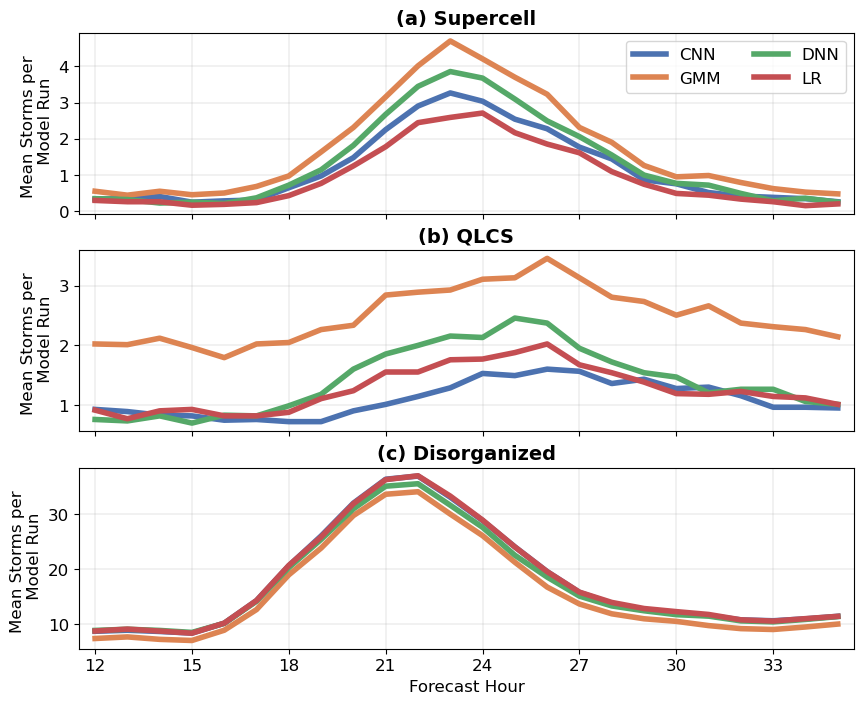

In [13]:
%%time
mode_list = ['Supercell', 'QLCS', 'Disorganized']

fig, axes = plt.subplots(3, 1, figsize=(10,8))
for i, ax in enumerate(axes.ravel()):
    plot_modes_diurnal_r(labels, mode_list[i], ax=ax)
    ax.set_xlabel(None)
    ax.set_xticks(np.arange(12, 37, 3)) 
    ax.set_xlim(11.5,35.5)
    ax.set_title('(%s) %s'%(panels[i], mode_list[i]), fontsize=14, weight='bold')
    ax.set_ylabel('Mean Storms per \n Model Run', fontsize=12)
    
    if i == 2: ax.set_xlabel('Forecast Hour', fontsize=12)
    if i == 0: ax.legend(prop={'size': 12}, ncol=2)
    if i in [0,1]: ax.set_xticklabels([])
    ax.grid(linewidth=0.25)

plt.savefig('diurnal_mode.pdf', dpi=300, bbox_inches='tight')